In [9]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import networkx as nx
%matplotlib inline

In [10]:
G = 9.81  # m/sec^2
KINEMATIC_VISCOSITY = 10 ** -6  # m/sec^2
my_pressure_list = [0.05, 0.1, 1, 5, 10, 15, 30, 50, 100]  # m. water
my_rate_list = [0, 0.01, 0.1, 0.2, 0.3, 0.5, 1, 5]  # m3/sec

In [11]:
"""
#     A  B  C  D  E  F  G  H  K  L
A = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],# A
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # B
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], # C
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # D
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # E
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # F
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # G
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # H
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # K
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] # L

GRAPH = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
layout = nx.spring_layout(GRAPH)
nx.draw(GRAPH, layout)
nx.draw_networkx_edge_labels(GRAPH, pos=layout)
plt.show()
"""

'\n#     A  B  C  D  E  F  G  H  K  L\nA = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],# A\n    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # B\n    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], # C\n    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # D\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # E\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # F\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # G\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # H\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # K\n    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] # L\n\nGRAPH = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)\nlayout = nx.spring_layout(GRAPH)\nnx.draw(GRAPH, layout)\nnx.draw_networkx_edge_labels(GRAPH, pos=layout)\nplt.show()\n'

In [12]:
class Pipeline:
    def __init__(self, name, length, inside_diameter):
        self.name = name
        self.length = length
        self.inside_diameter = inside_diameter

        self.pressure_characteristic = (
            self.calc_pressure_characteristic_of_the_pipeline()
        )

    @staticmethod
    def calc_reynolds_number(
        velocity: float, inside_diameter: float, kinematic_viscosity: float
    ) -> float:
        """Accept w, d, kv and return Re"""

        reynolds_number = velocity * inside_diameter / kinematic_viscosity

        return reynolds_number

    @staticmethod
    def calc_friction_coefficient(reynolds_number: float) -> float:
        """Accept Re and return lambda friction"""

        if reynolds_number < 2320:  # laminar
            try:
                lambda_friction = 64 / reynolds_number
            except ZeroDivisionError:
                lambda_friction = 0
        else:  # turbulent
            lambda_friction = 0.3164 / reynolds_number ** 0.25

        return lambda_friction

    @staticmethod
    def calc_hydraulic_losses(
        lambda_friction: float, inside_diameter: float, length: float, velocity: float
    ) -> float:
        """Accept lambda friction, L, d, w and return hydraulic losses (m)"""

        hydraulic_losses = (
            lambda_friction * (length * velocity ** 2) / (inside_diameter * 2 * G)
        )

        return hydraulic_losses

    def calc_pressure_characteristic_of_the_pipeline(self) -> list:
        """Accept length, d and return pressure characteristic using my_rate_list"""

        length = self.length
        inside_diameter = self.inside_diameter

        hydraulic_losses_list = list()

        for rate in my_rate_list:
            velocity = (4 * rate) / (np.pi * inside_diameter ** 2)

            reynolds_number = self.calc_reynolds_number(
                velocity=velocity,
                inside_diameter=inside_diameter,
                kinematic_viscosity=KINEMATIC_VISCOSITY,
            )

            lambda_friction = self.calc_friction_coefficient(
                reynolds_number=reynolds_number
            )

            hydraulic_losses = self.calc_hydraulic_losses(
                lambda_friction=lambda_friction,
                inside_diameter=inside_diameter,
                length=length,
                velocity=velocity,
            )

            hydraulic_losses_list.append(hydraulic_losses)

        return hydraulic_losses_list

    def plot_pressure_characteristic(self):
        """Plot pressure characteristic"""

        hydraulic_losses_list = self.pressure_characteristic
        plt.plot(my_rate_list, hydraulic_losses_list)
        plt.title(f"Pressure characteristic for pipeline {self.name}")
        plt.xlabel("rate, m3/sec")
        plt.ylabel("pressure losses, m. water")
        plt.show()

In [13]:
# pressure characteristic calculation

def calc_serial_connected_pipelines_characteristic(characteristic_list: list) -> list:
    """Accept list with characteristic of serial connected pipelines and return their total pressure characteristic"""

    rate_list = my_rate_list
    total_characteristic = np.zeros(shape=(1, len(rate_list)))

    for characteristic in characteristic_list:
        characteristic = np.array(characteristic)
        total_characteristic = total_characteristic + np.array(characteristic)

    total_characteristic = list(np.transpose(total_characteristic))

    return total_characteristic


def calc_parallel_connected_pipelines_characteristic(characteristic_list: list) -> list:
    """Accept list with characteristic of parallel connected pipelines and return their total pressure characteristic"""

    rate_list = my_rate_list

    all_intersection_values_list = list()
    for pressure in my_pressure_list:
        y_line = [pressure for _ in range(len(rate_list))]
        temp_list = list()

        for characteristic in characteristic_list:
            characteristic = np.array(characteristic)

            first_line = LineString(np.column_stack((characteristic, rate_list)))
            second_line = LineString(np.column_stack((y_line, rate_list)))
            intersection = first_line.intersection(second_line)

            target_pressure = intersection.y
            temp_list.append(target_pressure)

        all_intersection_values_list.append(temp_list)

    total_characteristic = [sum(i) for i in all_intersection_values_list]

    coefficients = np.polyfit(
        total_characteristic, my_pressure_list, 3
    )  # where 3 is the degree of freedom

    a, b, c, d = coefficients

    total_characteristic = [
        rate ** 3 * a + rate ** 2 * b + rate ** 1 * c + rate ** 0 * d
        for rate in rate_list
    ]

    print(f"polynomial function coefficients: {coefficients}")

    return total_characteristic

In [14]:
def calc_rate_for_characteristic(characteristic: list, delta_pressure: float) -> float:
    """Accept pressure characteristic and delta pressure, return rate"""

    y_line = [delta_pressure for _ in range(len(my_rate_list))]

    intersection = find_intersection(my_rate_list, characteristic, my_rate_list, y_line)

    plt.plot(my_rate_list, characteristic)
    plt.plot(my_rate_list, y_line)
    plt.title(f"Total pressure characteristic of system")
    plt.xlabel("rate, m3/sec")
    plt.ylabel("pressure losses, m. water")
    plt.axvline(intersection.x, color="r")
    plt.show()

    intersection = find_intersection(my_rate_list, characteristic, my_rate_list, y_line)
    rate = intersection.x

    return rate


def find_intersection(x1, y1, x2, y2):
    first_line = LineString(np.column_stack((x1, y1)))
    second_line = LineString(np.column_stack((x2, y2)))
    intersection = first_line.intersection(second_line)

    try:
        intersection_x = intersection.x
    except AttributeError as e:
        print(
            "There is no intersection for this data. Change delta pressure, range of rates or range of pressures"
        )
        raise e

    return intersection


def find_time_to_pump(volume: float, rate: float) -> float:

    return round(volume / rate, 0)

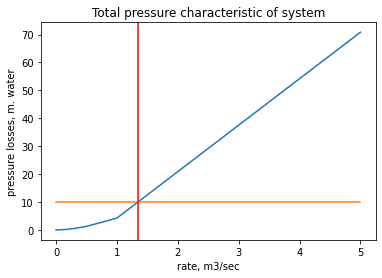

Example 1
Delta pressure: 10
Rate: 116322.80998883599, m3/day
Time to pump: 743.0 sec, 0.009 days


In [15]:
# example 1
# есть 1 участок, A-B, длинна 1 км, диаметр 0,7 м. Надо перекачать 1000 м3. Требуется определить время на перекачку.
volume = 1000  # m3
delta_pressure = 10
length = 1000
inside_diameter = 0.7

pipe_1 = Pipeline(name="AB", length=length, inside_diameter=inside_diameter)
rate = calc_rate_for_characteristic(
    characteristic=pipe_1.pressure_characteristic, delta_pressure=delta_pressure
)

print("Example 1")
print(f"Delta pressure: {delta_pressure}")
print(f"Rate: {rate * 86400}, m3/day")
time_to_pump = find_time_to_pump(volume=volume, rate=rate)
print(f"Time to pump: {time_to_pump} sec, {round(time_to_pump / 86400, 3)} days")

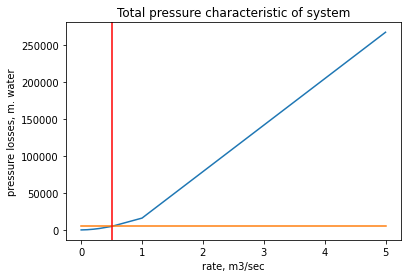

Example 2
Delta pressure: 5000
Rate: 44102.964914107375, m3/day
Time to pump: 1959.0 sec, 0.023 days


In [16]:
# example 2
# Пример задачи. Есть трубопровод из 4 участков, A (диаметр 0,7м)-B(диаметр 0,2м)-C(диаметр 0,15м)-D(диаметр 0,7м),
# каждый по 2 км. Надо перекачать 1000 м3. Требуется определить время на перекачку.
volume = 1000  # m3
delta_pressure = 5000
pipeline_dict = {
    "A": [2000, 0.7],
    "B": [2000, 0.2],
    "C": [2000, 0.15],
    "D": [2000, 0.7],
}

total_characteristic = list()
for pipe, values in pipeline_dict.items():
    temp_pipeline = Pipeline(name=pipe, length=values[0], inside_diameter=values[1])
    total_characteristic.append(temp_pipeline.pressure_characteristic)


system_characteristic = list(
    calc_serial_connected_pipelines_characteristic(total_characteristic)
)
rate = calc_rate_for_characteristic(
    characteristic=system_characteristic, delta_pressure=delta_pressure
)

print("""Example 2""")
print(f"Delta pressure: {delta_pressure}")
print(f"Rate: {rate * 86400}, m3/day")
time_to_pump = find_time_to_pump(volume=volume, rate=rate)
print(f"Time to pump: {time_to_pump} sec, {round(time_to_pump / 86400, 3)} days")

polynomial function coefficients: [-7.35577570e+00  1.27755546e-03  8.19641243e+05  3.99680289e-13]


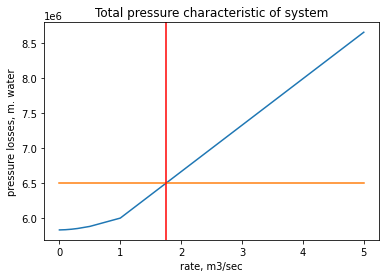

Example 3
Delta pressure: 6500000
Rate: 151787.3061672116, m3/day
Time to pump: 569217560.0 sec, 6588.166 days


In [18]:
# example 3
# Пример задачи. Есть трубопровод из 4 участков, A (диаметр 0,7м)-[ B(диаметр 0,2м)-C(диаметр 0,15м)]-D(диаметр 0,7м),
# каждый по 20 000 км. Надо перекачать 1000 000 000 м3. Требуется определить время на перекачку.
# [квадратные скобки] означают что два участка подключены параллельно.

volume = 1000000000
delta_pressure = 6500000
pipeline_dict = {
    "A": [20000000, 0.7],
    "B": [20000000, 0.2],
    "C": [20000000, 0.15],
    "D": [20000000, 0.7],
}


parallel_segment_characteristic_list = list()
others_segment_characteristic = list()
for pipe, values in pipeline_dict.items():
    temp_pipeline = Pipeline(name=pipe, length=values[0], inside_diameter=values[1])
    if pipe in ["B", "C"]:
        parallel_segment_characteristic_list.append(
            temp_pipeline.pressure_characteristic
        )
    else:
        others_segment_characteristic.append(temp_pipeline.pressure_characteristic)

parallel_segment_characteristic = calc_parallel_connected_pipelines_characteristic(
    parallel_segment_characteristic_list
)

total_characteristic = list()
total_characteristic.extend(others_segment_characteristic)
total_characteristic.extend(parallel_segment_characteristic)

system_characteristic = calc_serial_connected_pipelines_characteristic(
    total_characteristic
)
rate = calc_rate_for_characteristic(
    characteristic=system_characteristic, delta_pressure=delta_pressure
)

print("""Example 3""")
print(f"Delta pressure: {delta_pressure}")
print(f"Rate: {rate * 86400}, m3/day")
time_to_pump = find_time_to_pump(volume=volume, rate=rate)
print(f"Time to pump: {time_to_pump} sec, {round(time_to_pump / 86400, 3)} days")